In [22]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import dask
from dask.distributed import Client
from kneed import KneeLocator
import umap
import utils

# Repeat UMAP-DBSCAN runs to compute uncertainty

In [ ]:
#@dask.delayed
def compute_labels(df_train, df_store, iteration=0):    
    # compute embedding
    embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=20).fit_transform(df_train)

    # compute clustering
    model = DBSCAN(eps=0.1, min_samples=3).fit(embedding)

    # drop small clusters and set their label to -1
    temp = df_store.copy()
    temp["e0"] = embedding[:, 0]
    temp["e1"] = embedding[:, 1]
    temp["e2"] = embedding[:, 2]
    temp["label"] = model.labels_
    # print(len(temp))
    # temp, knee, thresh = utils.drop_clusters_with_few_samples(temp, thresh=None, plotting=False)
    # print(f"      {len(temp) -len(df_store)}")

    # store output
    temp.to_csv(f"output_old/dbscan/uncertainty/umap_dbscan_{iteration}.csv", index=False)

In [ ]:
# client = Client(n_workers=4)
# client

In [2]:
# load data
df_in = pd.read_csv("data/df_wide_knn.csv") 
df = df_in.drop(["LATITUDE", "LONGITUDE", "LEV_M"], axis=1)  # remove geolocation

# scale data
scaler = MinMaxScaler().fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

In [3]:
num_iterations = 100

# Re-run the UMAP-DBSCAN several times

In [ ]:
labels_list = []

for i in range(num_iterations):
    print(i)
    compute_labels(df_train=df_scaled, df_store=df_in, iteration=i)

# Compute dropout and scores

In [4]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

info = []
for i in range(num_iterations):
    print(i)
    # load data and compute thresh for automatic cluster-dropping
    filename = f"umap_dbscan_{i}.csv"
    df = pd.read_csv("output_old/dbscan/uncertainty/" + filename)
    df_dropped, knee, thresh = utils.drop_clusters_with_few_samples(df, thresh=None, plotting=False)

    # compute scores only on valid labels
    temp_dropped = df_dropped[df_dropped.label != -1]   
    si_dropped = silhouette_score(temp_dropped[["e0", "e1", "e2"]], temp_dropped["label"])
    db_dropped = davies_bouldin_score(temp_dropped[["e0", "e1", "e2"]], temp_dropped["label"])
    ch_dropped = calinski_harabasz_score(temp_dropped[["e0", "e1", "e2"]], temp_dropped["label"])

    temp = df[df.label != -1]
    si = silhouette_score(temp[["e0", "e1", "e2"]], temp["label"])
    db = davies_bouldin_score(temp[["e0", "e1", "e2"]], temp["label"])
    ch = calinski_harabasz_score(temp[["e0", "e1", "e2"]], temp["label"])

    # store everything
    temp_dropped.to_csv(f"output_old/dbscan/uncertainty/umap_dbscan_kneedrop_{i}.csv", index=False)
    temp_dropped_info = pd.DataFrame({"filename": [f"umap_dbscan_kneedrop_{i}.csv"], "thresh": [thresh], "silhouette": [si_dropped], "davies-bouldin": [db_dropped], "calinski-harabasz": [ch_dropped]})
    info.append(temp_dropped_info)

    temp_info = pd.DataFrame({"filename": [f"umap_dbscan_{i}.csv"], "thresh": [None], "silhouette": [si], "davies-bouldin": [db], "calinski-harabasz": [ch]})
    info.append(temp_info)

info = pd.concat(info)
info.to_csv("output_old/dbscan/uncertainty/info.csv", index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [33]:
info["dropped"] = info.filename.apply(lambda x: True if "kneedrop" in x else False)

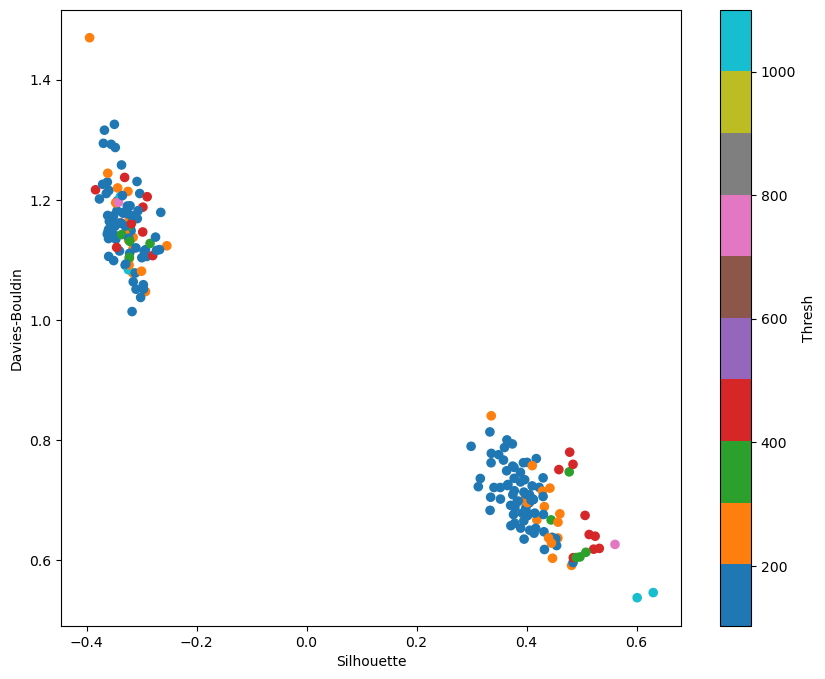

In [36]:
import matplotlib.pyplot as plt
import matplotlib as mpl

cm = mpl.colormaps["tab10"]
xy = range(20)
z = xy
sc = plt.scatter(info["silhouette"], info["davies-bouldin"], c=info["thresh"], s=35, cmap=cm)
plt.colorbar(sc, label="Thresh")
plt.xlabel("Silhouette")
plt.ylabel("Davies-Bouldin")
plt.show()

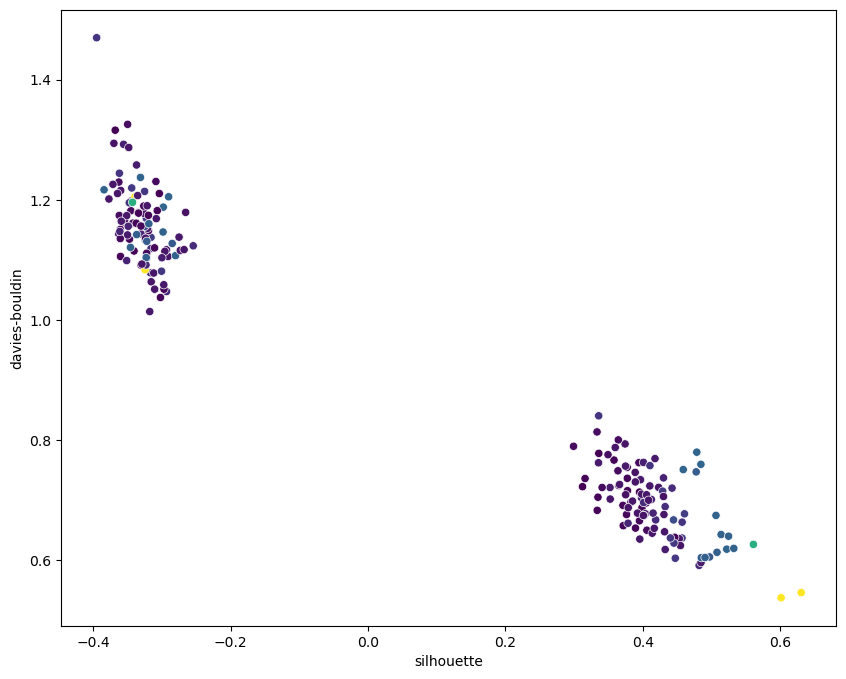

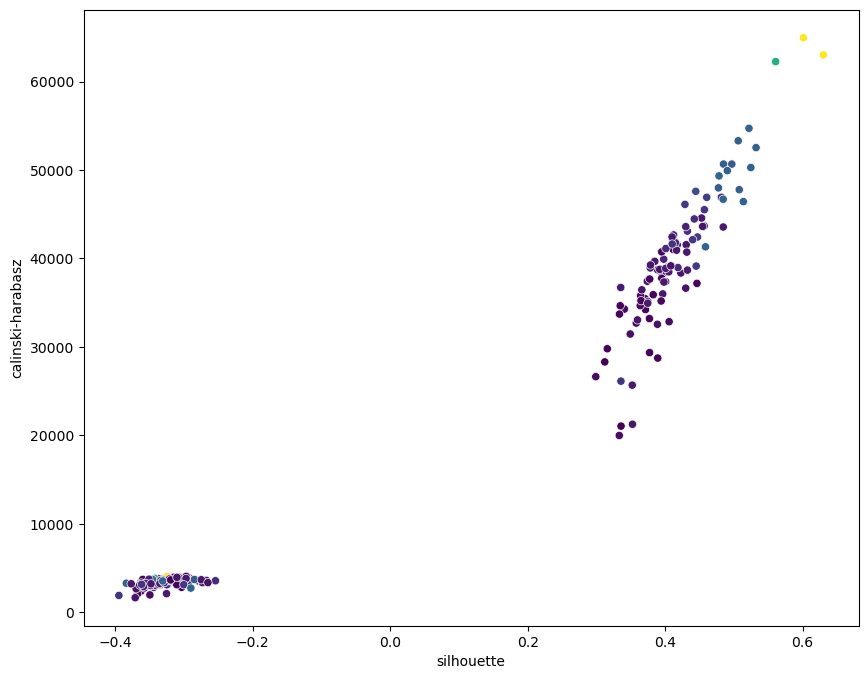

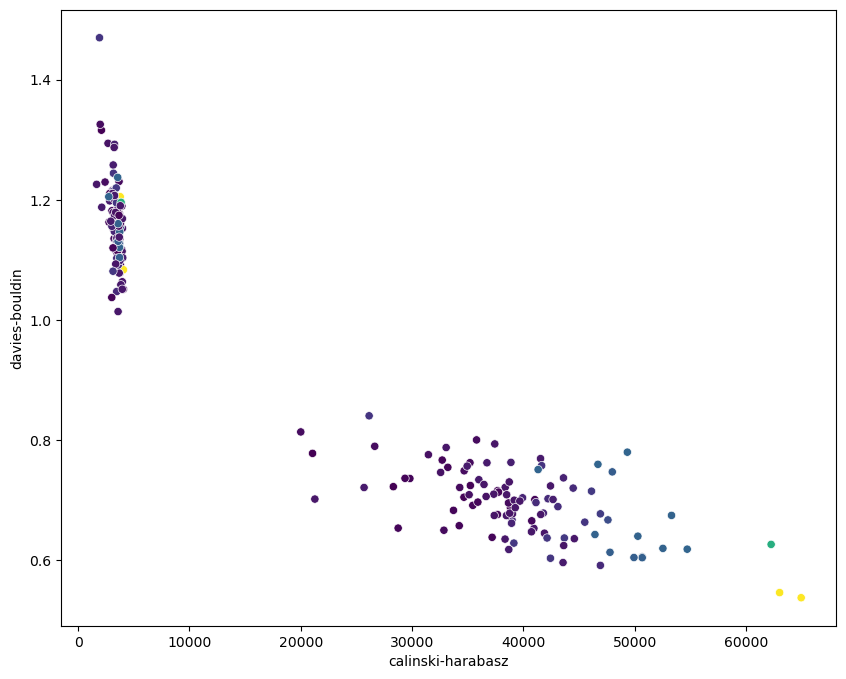

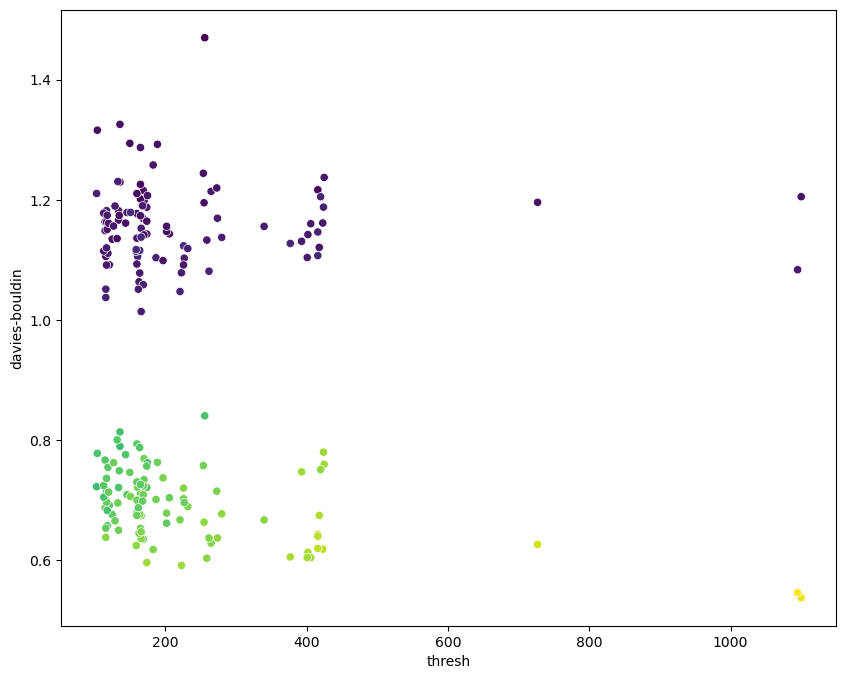

In [40]:
import matplotlib.pyplot as plt
s0 = sns.scatterplot(data=info, x="silhouette", y="davies-bouldin", c=info.thresh)
# plt.colorbar(s0)
plt.show()

sns.scatterplot(data=info, x="silhouette", y="calinski-harabasz", c=info.thresh)
plt.show()

sns.scatterplot(data=info, x="calinski-harabasz", y="davies-bouldin", c=info.thresh)
plt.show()

sns.scatterplot(data=info, x="thresh", y="davies-bouldin", c=info.silhouette)
plt.show()

<Axes: xlabel='thresh', ylabel='Count'>

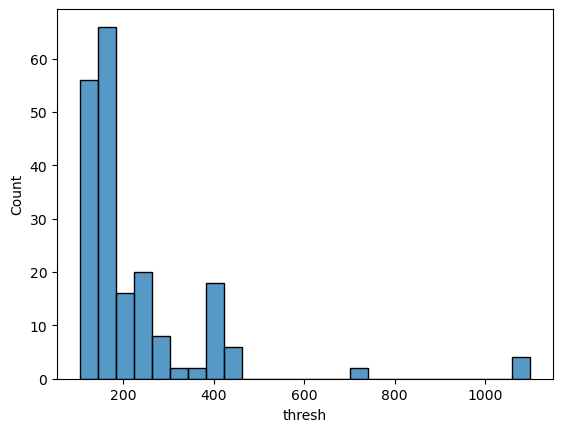

In [9]:
sns.histplot(info.thresh)

In [12]:
a = pd.read_csv("output_old/dbscan/uncertainty/umap_dbscan_kneedrop_0.csv")#.drop("Unnamed: 0", axis=1)
b = pd.read_csv("output_old/dbscan/uncertainty/umap_dbscan_kneedrop_1.csv")#.drop("Unnamed: 0", axis=1)

In [13]:
confusion = pd.merge(a[["LEV_M", "LATITUDE", "LONGITUDE", "label"]], 
                     b[["LEV_M", "LATITUDE", "LONGITUDE", "label"]], 
                     how="outer", 
                     on=["LEV_M", "LATITUDE", "LONGITUDE"], 
                     suffixes=["_0", "_1"])# [["label_0", "label_1"]])# .value_counts())# .reset_index()

In [14]:
c0_counts = pd.DataFrame(confusion.groupby("label_0").count().LATITUDE).rename(columns={"LATITUDE": "count"}).reset_index()
c1_counts = pd.DataFrame(confusion.groupby("label_1").count().LATITUDE).rename(columns={"LATITUDE": "count"}).reset_index()

In [15]:
overlap = pd.DataFrame(confusion.fillna(-1)[["label_0", "label_1"]].value_counts()).reset_index()

In [16]:
c1_counts

,label_1,count
0,0.0,4290
1,1.0,223
2,5.0,342
3,6.0,1717
4,14.0,262
5,15.0,1656
6,19.0,364
7,22.0,658
8,23.0,275
9,24.0,416


In [17]:
field_rel_to_c0 = field.copy().drop(-1, axis=1)
for c in field_rel_to_c0.columns:
    num_datapoints = c0_counts[c0_counts.label_0 == c]["count"].values[0]
    field_rel_to_c0[c] = field_rel_to_c0[c] / num_datapoints * 100

field_rel_to_c1 = field.copy().drop(-1, axis=0)
for idx, row in field_rel_to_c1.iterrows():
    num_datapoints = c1_counts[c1_counts.label_1 == idx]["count"].values[0]
    # print(row / num_datapoints * 100)
    field_rel_to_c1.loc[idx] = row / num_datapoints * 100

NameError: name 'field' is not defined

In [18]:
plt.rcParams["figure.figsize"] = (10, 8)
sns.heatmap(data=field_rel_to_c0, cbar_kws={'label': color}) #, annot=False)#, fmt='g')
plt.xlabel("Clustering 0")
plt.ylabel("Clustering 1")
plt.show()

NameError: name 'field_rel_to_c0' is not defined

In [19]:
plt.rcParams["figure.figsize"] = (10, 8)
sns.heatmap(data=field_rel_to_c1, cbar_kws={'label': color}) #, annot=False)#, fmt='g')
plt.xlabel("Clustering 0")
plt.ylabel("Clustering 1")
plt.show()

NameError: name 'field_rel_to_c1' is not defined

In [20]:
x="label_0"
y="label_1"f
color="count"
idx = overlap[y].unique()
cols = overlap[x].unique()

all_combos = pd.DataFrame(list(it.product(idx, cols)), columns=[x, y])
temp = pd.merge(all_combos, overlap, how="left", on=[x, y]).fillna(0)
field = pd.DataFrame(temp[color].to_numpy().reshape(len(idx), len(cols)), index=idx, columns=cols)

SyntaxError: invalid syntax (1390719468.py, line 2)

In [ ]:
plt.rcParams["figure.figsize"] = (10, 8)
sns.heatmap(data=(field), cbar_kws={'label': color}) #, annot=False)#, fmt='g')
plt.xlabel("Clustering 0")
plt.ylabel("Clustering 1")
plt.show()

In [ ]:
sns.histplot(confusion["count"])

In [ ]:
import itertools as it
temp = confusion.copy()
temp = temp.sort_values(["count"])

x="label_0"
y="label_1"
color="count"
idx = temp[y].unique()
cols = temp[x].unique()

all_combos = pd.DataFrame(list(it.product(idx, cols)), columns=[x, y])
temp = pd.merge(all_combos, temp, how="left", on=[x, y]).fillna(0)
field = pd.DataFrame(temp[color].to_numpy().reshape(len(idx), len(cols)), index=idx, columns=cols)

plt.rcParams["figure.figsize"] = (10, 8)
sns.heatmap(data=(field), cbar_kws={'label': color}) #, annot=False)#, fmt='g')
plt.xlabel("Clustering 0")
plt.ylabel("Clustering 1")
# plt.title(title)

# Cluster matching

## Step 1: Find maximum overlapping labels/clusters for each combination of clustering 

In [ ]:
# compare outputs matching by #overlapping samples
# num_iterations = len(res)
res_matching = []
for i in range(num_iterations):
    for j in range(num_iterations):
        if i != j:
            print(i, j)

            # load both label sets
            a = pd.read_csv(f"output_old/dbscan/uncertainty/clustering{i}.csv")
            b = pd.read_csv(f"output_old/dbscan/uncertainty/clustering{j}.csv")
            # a = pd.DataFrame(labels_list[i], columns=["label"])  # pd.read_csv(output_dir + f"eps_{eps}-min_samples_{min_samples}-iteration_{i}.csv")
            # b = pd.DataFrame(labels_list[j], columns=["label"])  # pd.read_csv(output_dir + f"eps_{eps}-min_samples_{min_samples}-iteration_{j}.csv")

            # compute number of clusters of both clusterings
            num_clusters_a = len(a['label'].unique())
            num_clusters_b = len(b['label'].unique())
            print(f"Number of clusters difference: {num_clusters_a - num_clusters_b}")

            # compare num samples per cluster
            num_samples_a = pd.DataFrame(a.value_counts()).reset_index()
            num_samples_b = pd.DataFrame(b.value_counts()).reset_index()

            # match clusters by computing sample overlap
            df_labels = a.copy()
            df_labels = df_labels.rename(columns={"label": "label_a"})
            df_labels = df_labels.merge(b[["LATITUDE", "LONGITUDE", "LEV_M", "label"]].rename(columns={"label": "label_b"}), how="outer", on=["LATITUDE", "LONGITUDE", "LEV_M"])
            # df_labels["label_a"] = a
            # df_labels["label_b"] = b

            # iterate over each cluster in a
            for c in np.sort(a["label"].unique()):
                # check potential matches (given label c (from clusterin a), which labels in clustering b are at the same points?
                matches = pd.DataFrame(df_labels[df_labels["label_a"] == c]["label_b"])
                match_counts = matches.value_counts().reset_index()
                num_matches = len(match_counts)

                # what is the cluster in b, that has most points in common with cluster c (from clustering a)?
                max_match = match_counts[match_counts["count"] == match_counts["count"].max()]

                # if all samples in c got assigned the same cluster in b, num_matches will be 1
                if num_matches != 0:
                    res_matching.append({"clustering_a": i, "clustering_b": j,
                                "label_a": c,
                                "label_b": max_match["label_b"].values[0],
                                "num_samples_a": len(matches),
                                "num_samples_max_match": max_match["count"].values[0],
                                "difference": len(matches) - max_match["count"].values[0]})
                else:
                    # if no matching cluster was found
                    res_matching.append({"clustering_a": i, "clustering_b": j,
                                "label_a": c,
                                "label_b": np.nan,
                                "num_samples_a": len(matches),
                                "num_samples_max_match": np.nan,
                                "difference": np.nan})

In [ ]:
df_overlap = pd.DataFrame(res_matching)
df_overlap.to_csv("output_old/dbscan/uncertainty/overlap_withDrop.csv", index=False)

## Step 2: Apply the label mapping, count the number of different labels, compute uncertainties

In [ ]:
df_overlap = pd.read_csv("output_old/dbscan/uncertainty/overlap_withDrop.csv")

In [ ]:
# we always need to start from clustering a (as this is how we have done the prvious computation step)

In [ ]:
%%time

uncertainty = df_in.copy()
uncertainty["uncertainty"] = 0

for i in range(num_iterations):
    for j in range(num_iterations):
        if j<i: 
            print(i, j)
            df_clustering_a = pd.read_csv(f"output_old/dbscan/uncertainty/clustering{i}.csv").rename(columns={"label": "label_a"})
            df_clustering_b = pd.read_csv(f"output_old/dbscan/uncertainty/clustering{j}.csv").rename(columns={"label": "label_b"})
    
            temp = df_clustering_a.copy()
            temp = temp.merge(df_clustering_b[["LATITUDE", "LONGITUDE", "LEV_M", "label_b"]], how="outer", on=["LATITUDE", "LONGITUDE", "LEV_M"])
    
            # define mapping between clustering a and b
            mapping_a_b = df_overlap[(df_overlap.clustering_a == i) & (df_overlap.clustering_b == j)][["label_a", "label_b"]]
            # mapping_b_a = df_overlap[(df_overlap.clustering_a == j) & (df_overlap.clustering_b == i)][["label_a", "label_b"]]
    
            # map labes from clustering a to labels from clustering b (and vice versa)
            temp["label_a_mapped"] = temp["label_a"].apply(lambda x: mapping_a_b[mapping_a_b.label_a.astype(float).astype(str) == str(float(x))].iloc[0].label_b)  # this is the label mapping
            # temp["label_b_mapped"] = temp["label_b"].apply(lambda x: mapping_b_a[mapping_b_a.label_b.astype(float).astype(str) == str(float(x))].iloc[0].label_a)  # this is the label mapping
    
            # uncertainty of clustering for given 2 clusterings
            temp["are_labels_unequal_ab"] = temp.label_a_mapped != temp.label_b
            temp["cur_uncertainty"] = temp["are_labels_unequal_ab"].astype(int)
            # temp["cur_uncertainty_ab"] = temp["are_labels_unequal_ab"].astype(int) 

            # temp["are_labels_unequal_ba"] = temp.label_b_mapped != temp.label_a
            # temp["cur_uncertainty_ba"] = temp["are_labels_unequal_ba"].astype(int) 

            # @todo in the previous step, we are just matching labels a-b (not b-a) - so we cannot compute the b-a matching here. would be nice to increase precision of our uncertainty estimate
            # # decide which uncertainty is worse a-b or b-a and choose it (take worst case uncertainty)
            # if temp["cur_uncertainty_ab"].sum() > temp["cur_uncertainty_ba"].sum():
            #     temp["cur_uncertainty"] = temp["cur_uncertainty_ab"]
            # else:
            #     temp["cur_uncertainty"] = temp["cur_uncertainty_ba"]

            # update overall uncertainty
            uncertainty = uncertainty.merge(temp[["LATITUDE", "LONGITUDE", "LEV_M", "cur_uncertainty"]], how="outer", on=["LATITUDE", "LONGITUDE", "LEV_M"])
            uncertainty["uncertainty"] = uncertainty["uncertainty"] + uncertainty["cur_uncertainty"]
            uncertainty = uncertainty.drop("cur_uncertainty", axis=1)

uncertainty["uncertainty"] = uncertainty["uncertainty"]/(num_iterations*(num_iterations-1)/2)*100

In [ ]:
uncertainty.to_csv("output_old/dbscan/uncertainty/uncertainty.csv", index=False)

# Plot uncertainties

In [ ]:
df_in = pd.read_csv("output_old/dbscan/uncertainty/uncertainty.csv")

In [ ]:
# compute embedding
embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=20).fit_transform(df_scaled)

# visualize embedding
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], alpha=0.08, s=2, marker=".")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")
ax.set_zlabel("Axis 2")
plt.tight_layout()
# plt.savefig("output/umap_space.png")
plt.show()

In [ ]:
df_in["e0"] = embedding[:, 0]
df_in["e1"] = embedding[:, 1]
df_in["e2"] = embedding[:, 2]

In [ ]:
sns.histplot(df_in["uncertainty"]) # many uncertain points...
plt.xlabel("Uncertainty [%]")
plt.tight_layout()
plt.savefig("output_old/dbscan/uncertainty/uncertainty_withDrop_histplot.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(2, 4))
sns.boxplot(df_in["uncertainty"]) # many uncertain points...
plt.ylabel("Uncertainty [%]")
plt.tight_layout()
plt.savefig("output_old/dbscan/uncertainty/uncertainty_withDrop_boxplot.png")
plt.show()

In [ ]:
# define Basemap
mymap = Basemap(llcrnrlon=df_in["LONGITUDE"].min(), llcrnrlat=df_in["LATITUDE"].min(), 
                urcrnrlon=df_in["LONGITUDE"].max(), urcrnrlat=df_in["LATITUDE"].max(), fix_aspect=False)

# plot
figsize = (6, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection='3d')
sc_3d = ax.scatter(df_in["LONGITUDE"], df_in["LATITUDE"], df_in["LEV_M"], c=df_in["uncertainty"], s=0.5, alpha=1, zorder=4)  # df["predictions"]
ax.add_collection3d(mymap.drawcoastlines(linewidth=0.5))
ax.set_box_aspect((np.ptp(df_in["LONGITUDE"]), np.ptp(df_in["LATITUDE"]), np.ptp(df_in["LEV_M"])/50))  # aspect ratio is 1:1:1 in data space
plt.gca().invert_zaxis()
plt.colorbar(sc_3d, location="bottom", fraction=0.05, pad=0.01, label="Uncertainty [%]")
plt.tight_layout()
plt.savefig("output_old/dbscan/uncertainty/uncertainty_withDrop_geospace.png")
plt.show()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection='3d')
sc_umap = ax.scatter(df_in["e0"], df_in["e1"], df_in["e2"], c=df_in["uncertainty"], alpha=0.8, zorder=4, s=1)  # , s=s, alpha=1, zorder=4)
plt.colorbar(sc_umap, location="bottom", fraction=0.05, pad=0.05, label="Uncertainty [%]")
plt.tight_layout()
plt.savefig("output_old/dbscan/uncertainty/uncertainty_withDrop_umapspace.png")
plt.show()